In [23]:
import tensorflow as tf
from vit_keras import vit
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [10]:
DATASET_PATH = "Dataset/images"

In [11]:
# Data Augmentation & Rescaling
data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [12]:
# Training data generator (80%)
train_generator = data_gen.flow_from_directory(
   DATASET_PATH ,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

# Validation data generator (20%)
validation_generator = data_gen.flow_from_directory(
   DATASET_PATH ,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)

Found 7207 images belonging to 30 classes.
Found 1788 images belonging to 30 classes.


In [13]:
vit_model = vit.vit_b32(
    image_size=224,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)

2025-05-05 20:15:02.419285: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/janha30372/.conda/envs/janha30372_environment/lib/python3.10/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


In [14]:
for layer in vit_model.layers[-20:]:
    layer.trainable = True

In [15]:
inputs = tf.keras.Input(shape=(224, 224, 3))

In [16]:
vit_output = vit_model(inputs)

In [17]:
# Custom classification head
x = tf.keras.layers.Flatten()(vit_output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)  
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x) 
outputs = tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')(x)


In [18]:
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [21]:
optimizer = Adam(learning_rate=3e-5, weight_decay=1e-4)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.3, 
    patience=3,  
    min_lr=1e-6,  
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  
    min_delta=0.002,  
    restore_best_weights=True
)


In [25]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,  
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr] 
)

Epoch 1/50
225/225 [==============================] - 501s 2s/step - loss: 3.4128 - accuracy: 0.0976 - val_loss: 2.3606 - val_accuracy: 0.5102 - lr: 3.0000e-05
Epoch 2/50
225/225 [==============================] - 316s 1s/step - loss: 2.3417 - accuracy: 0.3489 - val_loss: 1.1814 - val_accuracy: 0.7028 - lr: 3.0000e-05
Epoch 3/50
225/225 [==============================] - 322s 1s/step - loss: 1.5656 - accuracy: 0.5604 - val_loss: 0.7417 - val_accuracy: 0.7920 - lr: 3.0000e-05
Epoch 4/50
225/225 [==============================] - 320s 1s/step - loss: 1.1760 - accuracy: 0.6714 - val_loss: 0.5723 - val_accuracy: 0.8403 - lr: 3.0000e-05
Epoch 5/50
225/225 [==============================] - 316s 1s/step - loss: 0.9561 - accuracy: 0.7339 - val_loss: 0.4744 - val_accuracy: 0.8614 - lr: 3.0000e-05
Epoch 6/50
225/225 [==============================] - 317s 1s/step - loss: 0.7883 - accuracy: 0.7791 - val_loss: 0.4269 - val_accuracy: 0.8750 - lr: 3.0000e-05
Epoch 7/50
225/225 [====================

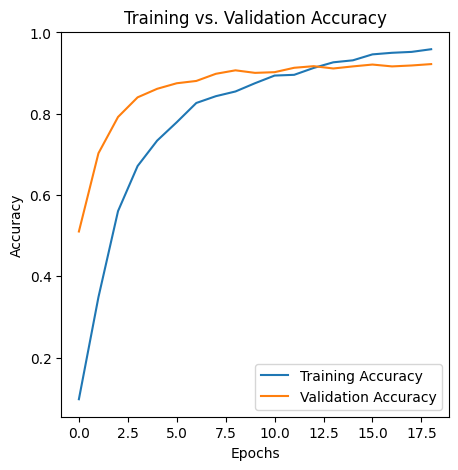

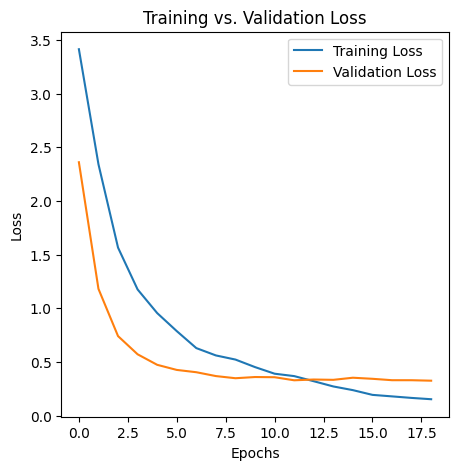

In [26]:
import matplotlib.pyplot as plt

history_dict = history.history  

plt.figure(figsize=(5, 5))
plt.plot(history_dict["accuracy"], label="Training Accuracy")
plt.plot(history_dict["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs. Validation Accuracy")
plt.show()


plt.figure(figsize=(5, 5))
plt.plot(history_dict["loss"], label="Training Loss")
plt.plot(history_dict["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs. Validation Loss")
plt.show()


In [27]:
from sklearn.metrics import classification_report
import numpy as np

y_true = []
y_pred = []

class_labels = list(train_generator.class_indices.keys())

for _ in range(len(validation_generator)):
    x_batch, y_batch = validation_generator.next()
    preds = model.predict(x_batch)
    y_true.extend(np.argmax(y_batch, axis=1))  
    y_pred.extend(np.argmax(preds, axis=1))   


print(classification_report(y_true, y_pred, target_names=class_labels))


1/1 [==============================] - 5s 5s/step
                       precision    recall  f1-score   support

         Ajanta Caves       0.74      0.73      0.73        62
            Amer Fort       1.00      0.92      0.96        59
Brihadeeswarar Temple       0.90      0.78      0.84        59
            Charminar       0.98      0.98      0.98        59
          City Palace       0.83      0.82      0.82        60
      Elephanta Caves       0.93      0.93      0.93        59
         Ellora Caves       0.68      0.70      0.69        60
       Fatehpur Sikri       0.93      0.97      0.95        59
     Gateway of India       0.97      1.00      0.98        59
        Golconda Fort       0.98      0.92      0.95        60
           Hawa Mahal       0.98      1.00      0.99        59
       Humayun's Tomb       0.95      0.98      0.97        59
       Jaisalmer Fort       0.97      0.98      0.97        59
          Jama Masjid       0.92      0.92      0.92        60
    

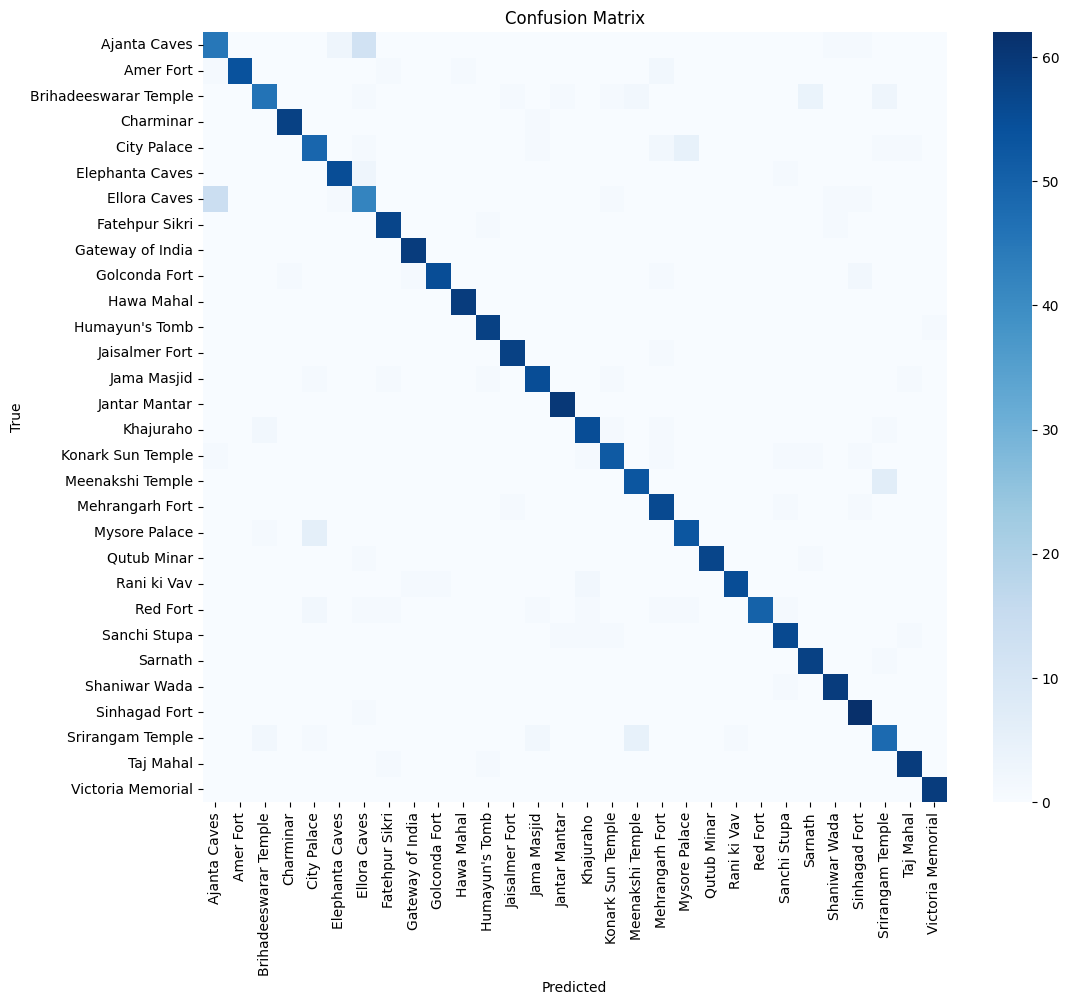

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


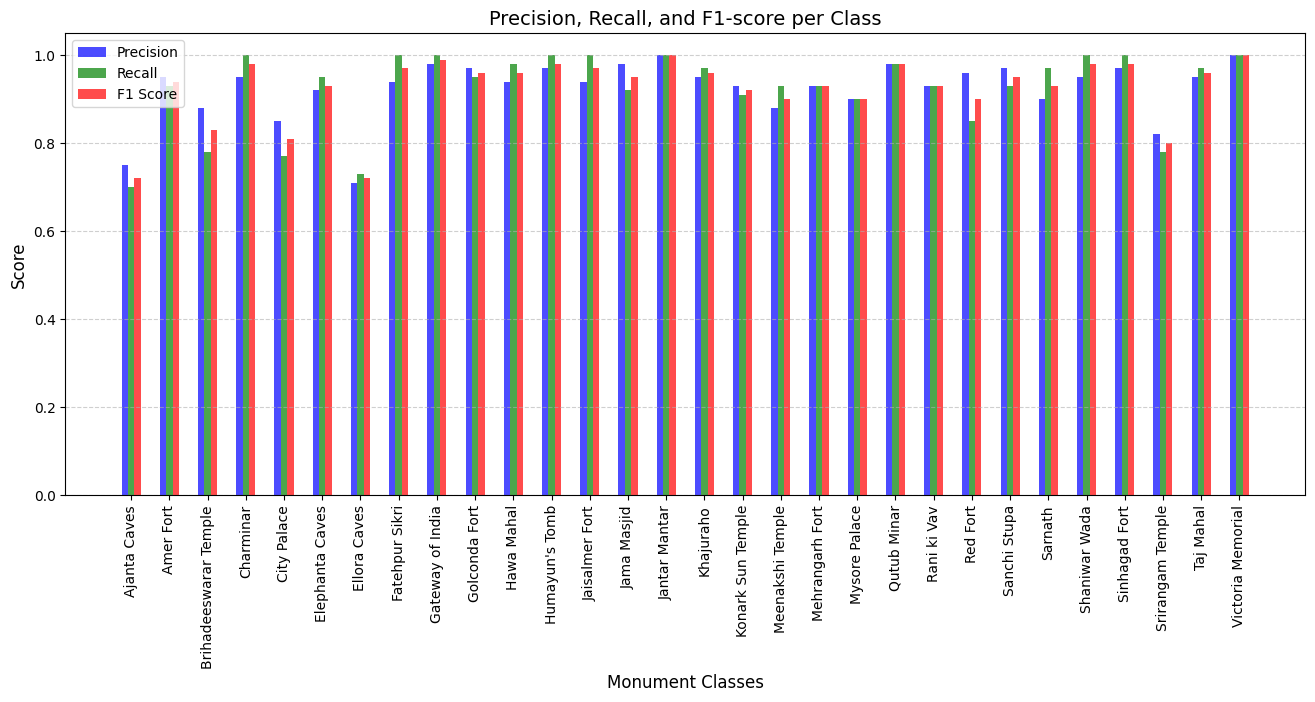

In [29]:
import numpy as np
import matplotlib.pyplot as plt


monuments = [
    "Ajanta Caves", "Amer Fort", "Brihadeeswarar Temple", "Charminar", "City Palace",
    "Elephanta Caves", "Ellora Caves", "Fatehpur Sikri", "Gateway of India", "Golconda Fort",
    "Hawa Mahal", "Humayun's Tomb", "Jaisalmer Fort", "Jama Masjid", "Jantar Mantar",
    "Khajuraho", "Konark Sun Temple", "Meenakshi Temple", "Mehrangarh Fort", "Mysore Palace",
    "Qutub Minar", "Rani ki Vav", "Red Fort", "Sanchi Stupa", "Sarnath",
    "Shaniwar Wada", "Sinhagad Fort", "Srirangam Temple", "Taj Mahal", "Victoria Memorial"
]


precision = [0.75, 0.95, 0.88, 0.95, 0.85, 0.92, 0.71, 0.94, 0.98, 0.97, 
             0.94, 0.97, 0.94, 0.98, 1.00, 0.95, 0.93, 0.88, 0.93, 0.90, 
             0.98, 0.93, 0.96, 0.97, 0.90, 0.95, 0.97, 0.82, 0.95, 1.00]

recall = [0.70, 0.93, 0.78, 1.00, 0.77, 0.95, 0.73, 1.00, 1.00, 0.95, 
          0.98, 1.00, 1.00, 0.92, 1.00, 0.97, 0.91, 0.93, 0.93, 0.90, 
          0.98, 0.93, 0.85, 0.93, 0.97, 1.00, 1.00, 0.78, 0.97, 1.00]

f1_score = [0.72, 0.94, 0.83, 0.98, 0.81, 0.93, 0.72, 0.97, 0.99, 0.96, 
            0.96, 0.98, 0.97, 0.95, 1.00, 0.96, 0.92, 0.90, 0.93, 0.90, 
            0.98, 0.93, 0.90, 0.95, 0.93, 0.98, 0.98, 0.80, 0.96, 1.00]

x = np.arange(len(monuments)) * 1.8 
width = 0.3  


plt.figure(figsize=(16, 6))
plt.bar(x - width, precision, width, label="Precision", color='b', alpha=0.7)
plt.bar(x, recall, width, label="Recall", color='g', alpha=0.7)
plt.bar(x + width, f1_score, width, label="F1 Score", color='r', alpha=0.7)


plt.xlabel("Monument Classes", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.title("Precision, Recall, and F1-score per Class", fontsize=14)
plt.xticks(ticks=x, labels=monuments, rotation=90, fontsize=10)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.show()



1/1 [==============================] - 0s 107ms/step


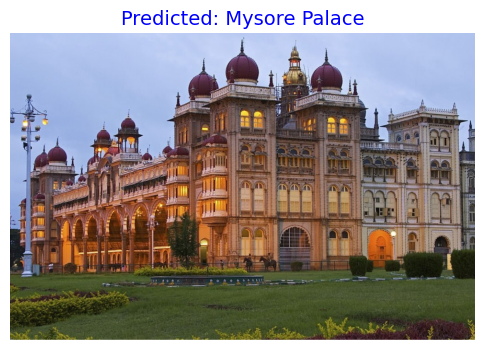

In [30]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def predict_monument(img_path, model, class_labels):
    
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0  

    
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds, axis=1)[0]  
    predicted_label = class_labels[predicted_class]  

    
    original_img = cv2.imread(img_path)  
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) 

   
    plt.figure(figsize=(6, 6))
    plt.imshow(original_img)  
    plt.axis("off")
    plt.title(f"Predicted: {predicted_label}", fontsize=14, color="blue")
    plt.show()

    return predicted_label


img_path = "Dataset/images/Mysore Palace/Image_4.jpg"  
predicted_monument = predict_monument(img_path, model, class_labels)


In [223]:
model.save("monument_recognition_model.h5")


/home/janha30372/.conda/envs/janha30372_environment/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
